In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import cv2
import gc
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [4]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [5]:
df = pd.read_csv(f"data/gas.csv")

In [6]:
# get last column number of unique values
n_classes = df.iloc[:,-1].nunique()
n_classes

6

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import os
import cv2

# Function to load and preprocess data
def load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=32, normalise = False):
    
    # Normalize df if normalise is True
    if normalise:
        scaler = MinMaxScaler()
        # Create a copy of the original DataFrame
        df_to_use = df.copy()

        # Normalize only the first 10 columns (quantitative columns)
        quantitative_columns = df.columns[:10]
        df_to_use[quantitative_columns] = scaler.fit_transform(df[quantitative_columns])
    else:
        df_to_use = df

    # Generate the images if the folder does not exist
    if not os.path.exists(images_folder):
        #Generate thet images
        #image_model.generateImages(df_to_use, images_folder)
        image_model.fit_transform(df_to_use, images_folder)
        image_model.saveHyperparameters(f'{images_folder}'+"/model.pkl")
    else:
        print("The images are already generated")

    img_paths = os.path.join(images_folder,problem_type+".csv")

    print(img_paths)

    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, df], axis=1)

    # Split data
    df_x = combined_dataset.drop(df.columns[-1], axis=1).drop("class", axis=1)
    df_y = combined_dataset["class"]

    X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size=0.20, random_state=SEED)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=SEED)
    # Numerical data
    X_train_num = X_train.drop("images", axis=1)
    X_val_num = X_val.drop("images", axis=1)
    X_test_num = X_test.drop("images", axis=1)

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

    #ONE HOT ENCODING FOR MULTICLASS PROBLEMS
    label_encoder = LabelEncoder()

    label_encoder.fit(y_train)

    # Transform the target variable using one-hot encoding
    y_train = label_encoder.transform(y_train)
    y_val = label_encoder.transform(y_val)
    y_test = label_encoder.transform(y_test)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)
    
    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)
    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.as_tensor(y_train, dtype=torch.long)
    y_val_tensor = torch.as_tensor(y_val, dtype=torch.long)
    y_test_tensor = torch.as_tensor(y_test, dtype=torch.long)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape, label_encoder 

# MODEL ARCHITECTURES

In [8]:
class Model1(nn.Module):
    def __init__(self, attributes, imgs_shape, device):
        super(Model1, self).__init__()
        self.device = device
        # MLP branch
        self.mlp_branch = nn.Sequential(
            nn.Linear(attributes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        ).to(device)
        
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=2),
            nn.ReLU(),
            nn.Flatten()
        ).to(device)
        
        # Calculate the size of the flattened CNN output
        cnn_output_size = 16 * (imgs_shape[1] - 1) * (imgs_shape[2] - 1)
        
        # Final MLP layers
        self.final_mlp = nn.Sequential(
            nn.Linear(16 + cnn_output_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, n_classes)
        ).to(device)
        
    def forward(self, mlp_input, cnn_input):
        mlp_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        mlp_output = self.mlp_branch(mlp_input)
        cnn_output = self.cnn_branch(cnn_input)
        
        # Concatenate the outputs of CNN and MLP branches
        concat_output = torch.cat((mlp_output, cnn_output), dim=1)
        
        # Final MLP layers
        final_output = self.final_mlp(concat_output)
        
        return final_output

In [9]:
class Model2(nn.Module):
    def __init__(self, attributes, imgs_shape, device):
        super(Model2, self).__init__()
        self.device = device
        
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        ).to(device)
        
        # MLP branch
        self.mlp_branch = nn.Sequential(
            nn.Linear(attributes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        ).to(device)
        
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)
        
        # Dense layers
        self.final_mlp = nn.Sequential(
            nn.Linear(self.flat_size + 16, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, n_classes)
        ).to(device)

    
    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_cnn_input = torch.zeros(1, *imgs_shape, device=self.device)
        cnn_output = self.cnn_branch(dummy_cnn_input)
        return cnn_output.size(1)

    
    def forward(self, mlp_input, img_input):
        mlp_input = mlp_input.to(self.device)
        img_input = img_input.to(self.device)
        # CNN branch
        cnn_output = self.cnn_branch(img_input)
        
        # MLP branch
        mlp_output = self.mlp_branch(mlp_input)

        # Combine CNN and MLP outputs
        merged = torch.cat((mlp_output, cnn_output), dim=1)
        
        # Final layers
        final_output = self.final_mlp(merged)
        return final_output

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os

def compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=32, epochs=100, min_lr=1e-3, max_lr=1, device='cuda', weight_decay=1e-2):
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=min_lr, weight_decay=weight_decay)
    
    total_steps = epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=max_lr/min_lr, total_steps=total_steps, pct_start=0.3, final_div_factor=1)
    
    best_val_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_patience = 20
    best_model = None
    best_epoch = 0
    warm_up_epochs = epochs*0.3

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': [], 'train_f1': [], 'val_f1': [], 'learning_rate': [], 'epoch_time': []}

    start_time = time.time()
    

    pbar = tqdm(range(epochs), desc='description', ncols=100)
    for epoch in pbar:
    #for epoch in range(epochs):
        epoch_start_time = time.time()

        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []
        for num_data, img_data, targets in train_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_targets.extend(targets.cpu().numpy())

        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for num_data, img_data, targets in val_loader:
                num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
                outputs = model(num_data, img_data)
                loss = loss_fn(outputs, targets)
                
                val_loss += loss.item()
                val_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()
        
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1
            #early_stopping_counter = 0
        #else:
            #if epoch > warm_up_epochs:
                #early_stopping_counter += 1
                #if early_stopping_counter >= early_stopping_patience:
                    #print(f"Early stopping triggered at epoch {epoch+1}")
                    #break

        train_accuracy = accuracy_score(train_targets, train_predictions)
        train_f1 = f1_score(train_targets, train_predictions, average='weighted')
        val_accuracy = accuracy_score(val_targets, val_predictions)
        val_f1 = f1_score(val_targets, val_predictions, average='weighted')

        epoch_time = time.time() - epoch_start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['learning_rate'].append(current_lr)
        history['epoch_time'].append(epoch_time)
        pbar.set_description("train_accuracy: %.2e | val_accuracy: %.2e" %
                                 (train_accuracy,
                                  val_accuracy))

    total_time = time.time() - start_time
    model.load_state_dict(best_model)

    # Calculate and save metrics
    train_metrics = calculate_metrics(model, train_loader, device)
    val_metrics = calculate_metrics(model, val_loader, device)
    test_metrics = calculate_metrics(model, test_loader, device)

    metrics = {
        'train_loss': train_metrics['loss'],
        'train_accuracy': train_metrics['accuracy'],
        'train_precision': train_metrics['precision'],
        'train_recall': train_metrics['recall'],
        'train_f1': train_metrics['f1'],
        'val_loss': val_metrics['loss'],
        'val_accuracy': val_metrics['accuracy'],
        'val_precision': val_metrics['precision'],
        'val_recall': val_metrics['recall'],
        'val_f1': val_metrics['f1'],
        'test_loss': test_metrics['loss'],
        'test_accuracy': test_metrics['accuracy'],
        'test_precision': test_metrics['precision'],
        'test_recall': test_metrics['recall'],
        'test_f1': test_metrics['f1'],
        'min_lr': min_lr,
        'max_lr': max_lr,
        'total_time': total_time,
        'average_epoch_time': sum(history['epoch_time']) / len(history['epoch_time'])
    }

    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best model found at epoch {best_epoch}/{epochs}")
    print(f"Best Train Loss: {history['train_loss'][best_epoch-1]:.4f}, Best Val Loss: {history['val_loss'][best_epoch-1]:.4f}")
    print(f"Best Train Accuracy: {history['train_accuracy'][best_epoch-1]:.4f}, Best Val Accuracy: {history['val_accuracy'][best_epoch-1]:.4f}")
    print(f"Best Train F1: {history['train_f1'][best_epoch-1]:.4f}, Best Val F1: {history['val_f1'][best_epoch-1]:.4f}")

    # Save figures for this fold
    os.makedirs(f"models/Multiclass/{dataset_name}/CNN+MLP/{model_name}", exist_ok=True)
    #plot_metric(history['train_loss'], history['val_loss'], 'Loss', dataset_name, model_name)
    plot_metric(history['train_accuracy'], history['val_accuracy'], 'Accuracy', dataset_name, model_name)
    # plot_metric(history['train_f1'], history['val_f1'], 'F1 Score', dataset_name, model_name)
    # plot_learning_rate(history['learning_rate'], dataset_name, model_name)

    # Save metrics to a file
    os.makedirs(f'logs/Multiclass/{dataset_name}/CNN+MLP/{model_name}', exist_ok=True)
    with open(f'logs/Multiclass/{dataset_name}/CNN+MLP/{model_name}/metrics.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')
            
    # Save best model
    model_save_path = f"models/Multiclass/{dataset_name}/CNN+MLP/{model_name}/best_model.pth"
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(best_model, model_save_path)
    print(f"Best model saved to {model_save_path}")
            
    del model
    torch.cuda.empty_cache()
    gc.collect()

    return metrics 


In [10]:
def calculate_metrics(model, data_loader, device):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for num_data, img_data, targets in data_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_predictions, average='weighted', zero_division=0)

    return {
        'loss': total_loss / len(data_loader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def plot_metric(train_metric, val_metric, metric_name, dataset_name, model_name):
    plt.figure()
    plt.plot(train_metric, label=f'Train {metric_name}')
    plt.plot(val_metric, label=f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f'{metric_name} vs. Epoch')
    # plt.savefig(f"models/Multiclass/{dataset_name}/CNN+MLP/{model_name}/{metric_name.lower()}_plot.png")
    # plt.close()

In [11]:
import traceback

def safe_compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=64, epochs=100, min_lr=1e-3, max_lr=1 , device='cuda', weight_decay=1e-2):
    try:
        if model is None:
            print(f"Model {model_name} is None")
            return None
        else:
            # Compile and fit the model
            metrics = compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, epochs=epochs, min_lr=min_lr, max_lr=max_lr, device=device, weight_decay=weight_decay)
            return metrics
    except Exception as e:
        print(f"Failed to compile and fit {model_name}: {str(e)}")
        traceback.print_exc()
        return None
    finally:
        # Clear CUDA cache and force garbage collection
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

In [12]:
import traceback

def try_create_model(model_class, attributes, imgs_shape, device):
    try:
        model = model_class(attributes, imgs_shape, device)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [13]:
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

12


In [14]:
from TINTOlib.igtd import IGTD
dataset_name='gas'
#Select the model and the parameters
problem_type = "supervised"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', error='abs', max_step=30000, val_step=300, random_seed=SEED)
name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Multiclass/{dataset_name}/images_{dataset_name}_{name}"

In [15]:
batch_size=64

In [16]:
train_loader, val_loader, test_loader, attributes, imgs_shape, label_encoder = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
../HyNNImages/Multiclass/gas/images_gas_IGTD_12x12_fEuclidean_iEuclidean_abs\supervised.csv
Images shape:  (3, 12, 12)
Attributes:  129


In [51]:
model1 = try_create_model(Model1, attributes, imgs_shape, device)  # Attempt to create Model1

Successfully created and tested Model1


Successfully created and tested Model1


train_accuracy: 9.90e-01 | val_accuracy: 9.85e-01: 100%|████████████| 15/15 [00:34<00:00,  2.30s/it]



Training completed in 34.47 seconds
Best model found at epoch 9/15
Best Train Loss: 0.1033, Best Val Loss: 0.1133
Best Train Accuracy: 0.9790, Best Val Accuracy: 0.9827
Best Train F1: 0.9791, Best Val F1: 0.9827
Best model saved to models/Multiclass/gas/CNN+MLP/IGTD_12x12_fEuclidean_iEuclidean_abs_Model1/best_model.pth


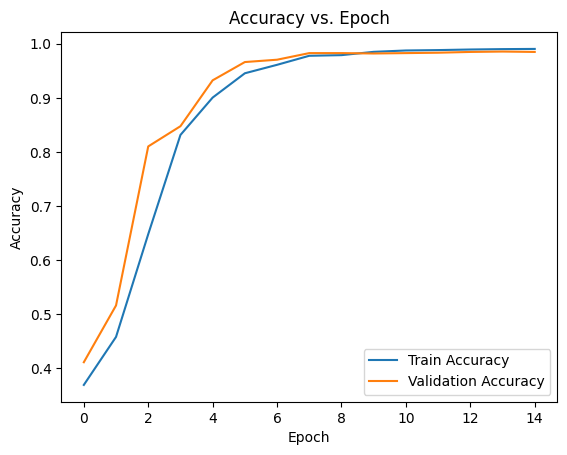

In [32]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape, device)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name,
                                      f"{name}_Model1", min_lr=1e-7, max_lr=1e-3, epochs=15)  # Train and evaluate Model1

Successfully created and tested Model2


train_accuracy: 9.96e-01 | val_accuracy: 9.94e-01: 100%|████████████| 15/15 [00:40<00:00,  2.73s/it]



Training completed in 40.92 seconds
Best model found at epoch 14/15
Best Train Loss: 0.0195, Best Val Loss: 0.0264
Best Train Accuracy: 0.9955, Best Val Accuracy: 0.9935
Best Train F1: 0.9955, Best Val F1: 0.9935
Best model saved to models/Multiclass/gas/CNN+MLP/IGTD_12x12_fEuclidean_iEuclidean_abs_Model2/best_model.pth


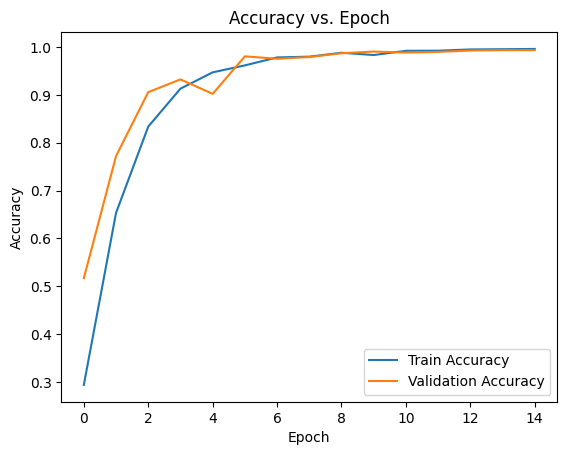

In [31]:
# Create and train Model1
model2 = try_create_model(Model2, attributes, imgs_shape, device)  # Attempt to create Model1
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, 
                                      f"{name}_Model2", min_lr=1e-8, max_lr=1e-3, epochs=15)  # Train and evaluate Model1

# Hybrid KAN

In [23]:
class Model3(nn.Module):
    def __init__(self, attributes, imgs_shape, device):
        super(Model3, self).__init__()
        self.device = device
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=2),
            nn.ReLU(),
            nn.Flatten()
        ).to(device)
        # Final KAN layers
        self.m_kan = KAN(
            width=[attributes, 2],
            grid=3,
            k=3,
            device=device
        )
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)
        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + 2, n_classes],
            grid=3,
            k=3,
            device=device
        )
    
    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_cnn_input = torch.zeros(1, *imgs_shape, device=self.device)
        cnn_output = self.cnn_branch(dummy_cnn_input)
        return cnn_output.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [33]:
model3 = try_create_model(Model3, attributes, imgs_shape, device)  # Attempt to create Model3
model3.m_kan.speed()
model3_metrics = compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, 
                                 f"{name}_Model3", min_lr=1e-7, max_lr=4e-3, epochs=2)  # Train and evaluate Model1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


description:   0%|                                                            | 0/2 [06:38<?, ?it/s]


KeyboardInterrupt: 

In [18]:
def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (mlp_tensor, img_tensor, target_tensor)
    """
    mlp_list, img_list, target_list = [], [], []
    for mlp, img, target in loader:
        mlp_list.append(mlp)
        img_list.append(img)
        target_list.append(target)
    return torch.cat(mlp_list, dim=0), torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

In [19]:
# Combine dataloaders into tensors.
train_mlp, train_img, train_target = combine_loader(train_loader)
val_mlp, val_img, val_target = combine_loader(val_loader)
test_mlp, test_img, test_target = combine_loader(test_loader)

dataset = {
    "train_mlp": train_mlp.to(device),
    "train_img": train_img.to(device),
    "train_target": train_target.to(device),
    "val_mlp": val_mlp.to(device),
    "val_img": val_img.to(device),
    "val_target": val_target.to(device),
    "test_mlp": test_mlp.to(device),
    "test_img": test_img.to(device),
    "test_target": test_target.to(device),
}

In [20]:
import os
import time
import copy
import numpy as np
import torch
import torch.optim as optim
from torch.optim import LBFGS
from tqdm import tqdm
import matplotlib.pyplot as plt

def fit_hybrid_dataloaders(model, 
                           dataset,
                           opt="Adam", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for validation
        - test_loader: provides (mlp, img, target) for evaluation during training

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.m_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.m_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.m_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_mlp"].shape[0]
    n_eval  = dataset["test_mlp"].shape[0]  # using test set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {
        'train_loss': [],
        'eval_loss': [],
        'val_loss': [],
        'reg': []
    }

    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)

        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_mlp"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_target"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    #model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    #model.final_kan.node_attribute()
                reg_val_inner = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            model.m_kan.update_grid(dataset["train_mlp"][train_indices])
            # output = model.get_concat_output(dataset["train_mlp"], dataset["train_img"])
            # model.final_kan.update_grid(output[train_indices])

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = closure()  # re-evaluate to record loss
            # Compute reg_val separately for logging
            with torch.no_grad():
                mlp_batch = dataset["train_mlp"][train_indices]
                img_batch = dataset["train_img"][train_indices]
                target_batch = dataset["train_target"][train_indices]
                outputs = model(mlp_batch, img_batch)
                train_loss = loss_fn(outputs, target_batch)
                if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                    if reg_metric == 'edge_backward':
                        model.m_kan.attribute()
                        #model.final_kan.attribute()
                    if reg_metric == 'node_backward':
                        model.m_kan.node_attribute()
                        #model.final_kan.node_attribute()
                    reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                    #reg_val = (reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff))/2
                else:
                    reg_val = torch.tensor(0., device=device)
        else:  # Adam branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_mlp"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_target"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    #model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    #model.final_kan.node_attribute()
                reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                #reg_val = (reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff))/2
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()

        # Evaluate on the entire evaluation set (from test_loader)
        mlp_eval = dataset["test_mlp"][eval_indices]
        img_eval = dataset["test_img"][eval_indices]
        target_eval = dataset["test_target"][eval_indices]
        eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        # New: Compute validation loss if validation data exists in the dataset.
        # val_loss = loss_fn(model(dataset['val_mlp'][eval_indices], dataset['val_img'][eval_indices]), dataset['val_target'][eval_indices])
        # results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            desc = ""
            data = []
            for metric in display_metrics:
                desc += f" {metric}: %.2e |"
                data.append(results[metric.__name__][-1])
            pbar.set_description(desc % tuple(data))

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.m_kan, "save_act", False)
            model.m_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.m_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.m_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.m_kan, "log_history"):
        model.m_kan.log_history('fit')

    return results

In [21]:
def train_acc():
    return torch.mean((torch.argmax(model3(dataset['train_mlp'], dataset['train_img']), dim=1) == dataset['train_target']).float())

def test_acc():
    return torch.mean((torch.argmax(model3(dataset['val_mlp'], dataset['val_img']), dim=1) == dataset['val_target']).float())

In [22]:
model3 = try_create_model(Model3, attributes, imgs_shape, device)  # Attempt to create Model3

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


In [38]:
model3_metrics = compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, 
                                 f"{name}_Model3", min_lr=1e-6, max_lr=4e-3, epochs=5)  # Train and evaluate Model1

description:   0%|                                                            | 0/5 [04:36<?, ?it/s]


KeyboardInterrupt: 

In [23]:
model3 = try_create_model(Model3, attributes, imgs_shape, device)
metrics3 = fit_hybrid_dataloaders(model3, dataset, opt="Adam",
                                  metrics=(train_acc, test_acc),
                                  loss_fn=torch.nn.CrossEntropyLoss(),
                                  steps=5) #0 y 2

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.47e+01 | eval_loss: 6.98e+01 | reg: 0.00e+00 |: 100%|█| 5/5 [03:49<00:00, 45.94s/it]


saving model version 0.1


In [24]:
print(metrics3['train_acc'][-1], metrics3['test_acc'][-1])

0.20983105897903442 0.22214235365390778


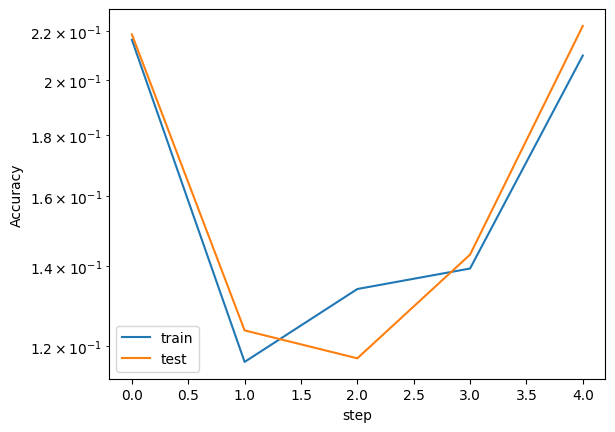

In [26]:
plt.plot(metrics3['train_acc'])
plt.plot(metrics3['test_acc'])
plt.legend(['train', 'test'])
plt.ylabel('Accuracy')
plt.xlabel('step')
plt.yscale('log')

In [ ]:
model3 = try_create_model(Model3, attributes, imgs_shape, device)
metrics3 = fit_hybrid_dataloaders(model3, dataset, opt="LBFGS",
                                  metrics=(train_acc, test_acc),
                                  loss_fn=torch.nn.CrossEntropyLoss(),
                                  steps=5)
print(metrics3['train_acc'][-1], metrics3['test_acc'][-1])

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


Training:   0%|                                                               | 0/5 [00:00<?, ?it/s]

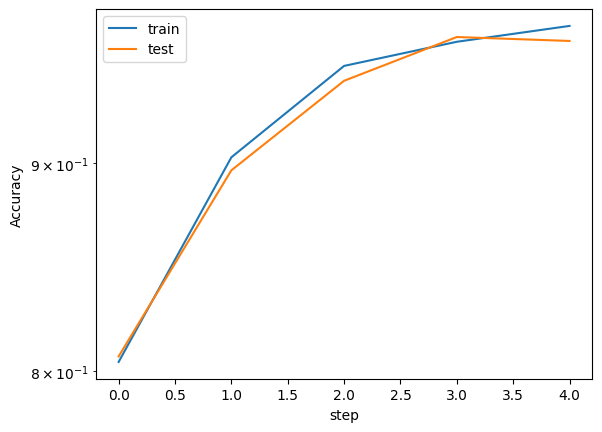

In [24]:
plt.plot(metrics3['train_acc'])
plt.plot(metrics3['test_acc'])
plt.legend(['train', 'test'])
plt.ylabel('Accuracy')
plt.xlabel('step')
plt.yscale('log')

In [ ]:
model3.final_kan.plot()

In [24]:
class Model4(nn.Module):
    def __init__(self, attributes, imgs_shape, device):
        super(Model4, self).__init__()
       # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 8, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        ).to(device)
        # Final KAN layers
        self.m_kan = KAN(
            width=[attributes, 2],
            grid=3,
            k=3,
            seed=SEED,
            device=device
        )
        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + 2, n_classes],
            grid=3,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)        
    
    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_cnn_input = torch.zeros(1, *imgs_shape, device=self.device)
        cnn_output = self.cnn_branch(dummy_cnn_input)
        return cnn_output.size(1)

    
    def forward(self, mlp_input, img_input):
        mlp_input = mlp_input.to(self.device)
        img_input = img_input.to(self.device)
        # CNN branch
        cnn_output = self.cnn_branch(img_input)
        
        # MLP branch
        mlp_output = self.m_kan(mlp_input)

        # Combine CNN and MLP outputs
        merged = torch.cat((mlp_output, cnn_output), dim=1)
        
        # Final layers
        final_output = self.final_kan(merged)
        return final_output

In [26]:
def train_acc():
    return torch.mean((torch.argmax(model4(dataset['train_mlp'], dataset['train_img']), dim=1) == dataset['train_target']).float())

def test_acc():
    return torch.mean((torch.argmax(model4(dataset['val_mlp'], dataset['val_img']), dim=1) == dataset['val_target']).float())

In [27]:
model4 = try_create_model(Model4, attributes, imgs_shape, device)
metrics4 = fit_hybrid_dataloaders(model4, dataset, opt="Adam",
                                  metrics=(train_acc, test_acc),
                                  loss_fn=torch.nn.CrossEntropyLoss(),
                                  steps=5)
print(metrics4['train_acc'][-1], metrics4['test_acc'][-1])

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.63e+01 | eval_loss: 3.57e+01 | reg: 0.00e+00 |: 100%|█| 5/5 [00:17<00:00,  3.40s/it]

saving model version 0.1
0.11637311428785324 0.12293314188718796


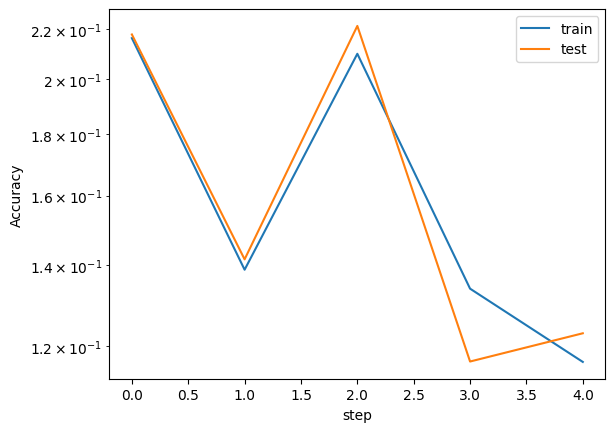

In [28]:
plt.plot(metrics4['train_acc'])
plt.plot(metrics4['test_acc'])
plt.legend(['train', 'test'])
plt.ylabel('Accuracy')
plt.xlabel('step')
plt.yscale('log')

In [33]:
model4 = try_create_model(Model4, attributes, imgs_shape, device)
metrics4 = fit_hybrid_dataloaders(model4, dataset, opt="LBFGS",
                                  metrics=(train_acc, test_acc),
                                  loss_fn=torch.nn.CrossEntropyLoss(),
                                  steps=10)
print(metrics4['train_acc'][-1], metrics4['test_acc'][-1])

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.35e-01 | eval_loss: 4.90e-01 | reg: 0.00e+00 |: 100%|█| 10/10 [08:25<00:00, 50.59s/i

saving model version 0.1
0.9334112405776978 0.9273903965950012


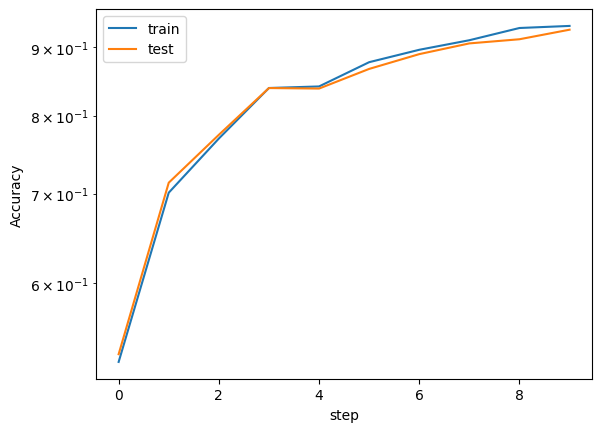

In [34]:
plt.plot(metrics4['train_acc'])
plt.plot(metrics4['test_acc'])
plt.legend(['train', 'test'])
plt.ylabel('Accuracy')
plt.xlabel('step')
plt.yscale('log')

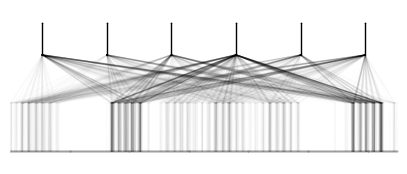

In [35]:
model4.final_kan.plot()